some of this code was inspired by https://github.com/mtrencseni/pytorch-playground/blob/master/05-cifar-10/CIFAR-10.ipynb

In [1]:
DATASET = 'CIFAR10' # choose dataset (CIFAR10, CIFAR100-20, or STL10)

In [2]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# transform/modify the images to prevent overfitting
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # will randomly flip images
    transforms.ToTensor(),
    transforms.RandomErasing(), # will erase random chunks of an image
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# each set is loaded a bit differently
def load(dataset):
    if dataset == 'CIFAR10':
        trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
        testset  = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)
        return trainset, testset
    elif dataset == 'CIFAR100-20':
        trainset = datasets.CIFAR100(root='./data/cifar100', train=True, download=True, transform=transform)
        testset  = datasets.CIFAR100(root='./data/cifar100', train=False, download=True, transform=transform)
        return trainset, testset
    elif dataset == 'STL10':
        # note the use of split='train' here instead of train=True
        trainset = datasets.STL10(root='./data/stl10', split='train', download=True, transform=transform)
        testset  = datasets.STL10(root='./data/stl10', split='test', download=True, transform=transform)
        return trainset, testset

trainset, testset = load(DATASET)
classes = trainset.classes # grab an array of classnames

# wrap in a dataloader -- for use in the CNN
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


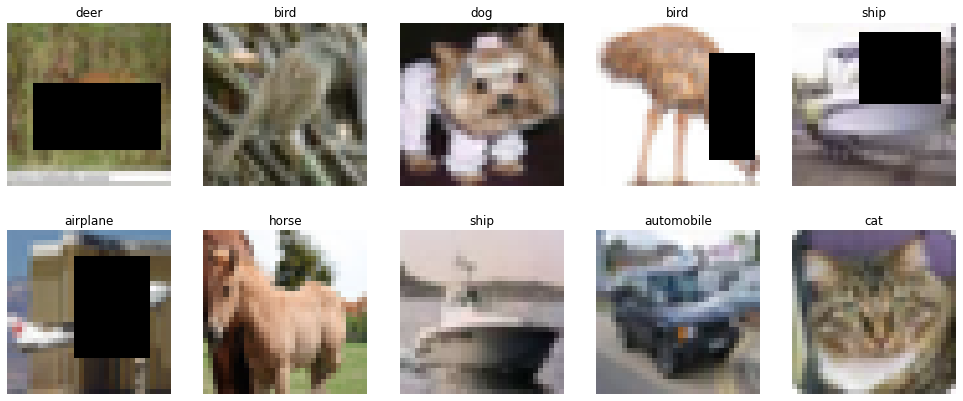

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# quick function to un-normalize and transpose images before graphing
def imshow(img):
    img = img / 2 + 0.5 # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

figure = plt.figure(figsize=(17, 7))
for i in range(1, 11):
    figure.add_subplot(2, 5, i)
    image, label = next(iter(trainloader))
    plt.title(classes[label[0].item()])
    plt.axis("off")
    img = image[0].squeeze()
    label = label[0]
    imshow(make_grid(img))
plt.show()

In [4]:
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

shape = 256 * 9 * 9 if DATASET == 'STL10' else 64 * 4 * 4 
output_size = 100 if DATASET == 'CIFAR100-20' else 10

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(shape, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [5]:
def train(model, trainloader, optimizer):
    losses = []
    model.train()
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [6]:
import torch

def test(model, testloader):
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss += F.nll_loss(outputs, labels, reduction='sum').item()
            prediction = outputs.argmax(dim=1, keepdim=True)
            correct += prediction.eq(labels.view_as(prediction)).sum().item()
    loss /= len(testloader.dataset)
    if epoch % 5 == 4:
        print('itr: {}, loss: {:.4f}, accuracy: {:.0f}%'.format(epoch, loss, 100. * correct / len(testloader.dataset)))
    return (float(correct) / len(testloader.dataset))


In [7]:
loss, accuracy = [], []
epochs = 30 if DATASET == 'CIFAR100-20' else 20 # need to train a bit longer for cifar100

print('begin training')

for epoch in range(0, epochs):
    loss.extend(train(model, trainloader, optimizer))
    accuracy.append(test(model, trainloader))

print('training complete')

begin training
itr: 4, loss: 0.8220, accuracy: 71%
itr: 9, loss: 0.6024, accuracy: 79%
itr: 14, loss: 0.4998, accuracy: 82%
itr: 19, loss: 0.4420, accuracy: 85%
training complete


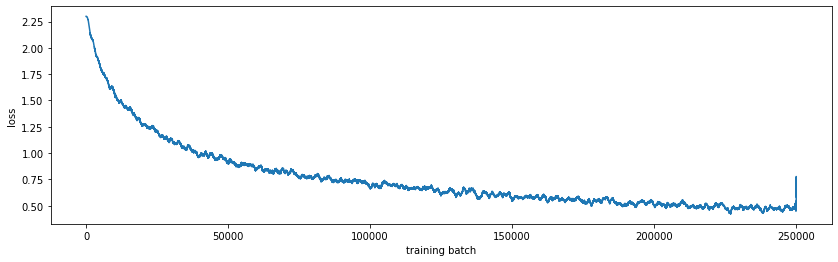

In [14]:
def mean(x): 
    return sum(x)/len(x)

plt.figure(figsize=(14, 4))
plt.xlabel('training batch')
plt.ylabel('loss')
plt.plot([mean(loss[i:i+1000]) for i in range(len(loss))])

In [15]:
def get_predictions(model, testloader):
    model.eval()
    y_test, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            prediction = outputs.argmax(dim=1, keepdim=True)
            y_test.extend(labels.view_as(prediction))
            y_pred.extend(prediction)
    return [y.item() for y in y_test], [y.item() for y in y_pred]

y_test, y_pred = get_predictions(model, testloader)

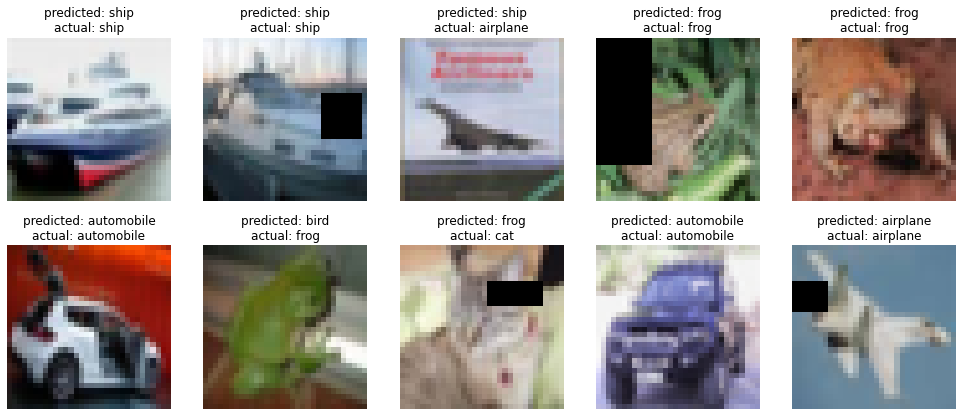

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# quick function to un-normalize and transpose images before graphing
def imshow(img):
    img = img / 2 + 0.5 # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

fig = plt.figure(figsize=(17, 7))
for index in range(1, 11):
    plt.subplot(2, 5, index)
    plt.axis('off')
    imshow(make_grid(testloader.dataset[index][0]))

    plt.title(
        'predicted: ' + classes[y_pred[index]] + 
        '\nactual: ' + classes[testloader.dataset[index][1]])

In [20]:
import numpy as np 
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

headers = ['ACC', 'NMI', 'ARI']
data = [[
    accuracy_score(y_test, y_pred),
    normalized_mutual_info_score(y_test, y_pred),
    adjusted_rand_score(y_test, y_pred)
]]

table = pd.DataFrame(data, columns=headers)
table

,ACC,NMI,ARI
0,0.7534,0.579891,0.543545


Text(0.5, 1.0, 'accuracy score: 75%')

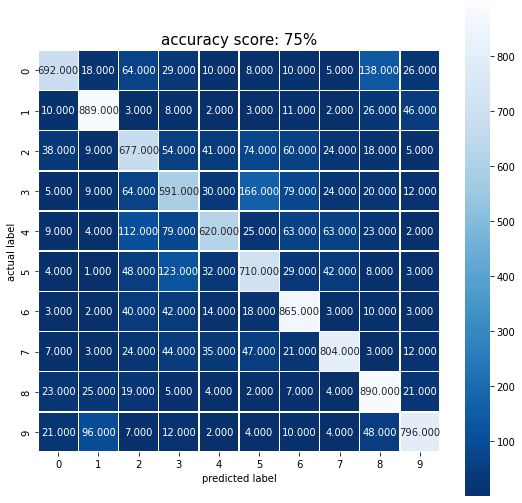

In [21]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt 

title = 'accuracy score: {:.0%}'.format(accuracy_score(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(
    cm, annot=True, fmt='0.3f', linewidths=0.5, square=True, cmap='Blues_r'
)
plt.ylabel('actual label')
plt.xlabel('predicted label')
plt.title(title, size=15)